In [2]:
import data_module as dt
import numpy as np
import pandas as pd
import tifffile as tiff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [3]:
%%capture
%pip install Cython
%pip install hdbscan
%pip install umap-learn
%pip install umap-learn[plot]

import hdbscan
import umap
import umap.plot

# Object Oriented Database Creation 

In this notebook we will demonstrate usage of the **ROI** class to automate database generation. Here database creation requires two steps. 

1. Instantiate an instance of the **ROI** class and call the class method **get**. The method takes 3 arguments 

    1. 'props_list', a list of properties for skimage to compute.
    2. 'image_list', list of tiff images 
    3. 'roi_size', roi size, this roi size corresponds to 1/2 the side length of a roi
    #

2. Call the methods **crop** and **gen_df** on the instance you instantiated in the last step

We can then use UMAP and HDBSCAN to find meaningful groupings within our dataset

In [4]:
props_list = props_list = ['area', 'solidity', 'perimeter_crofton', 
                           'eccentricity', 'axis_major_length','axis_minor_length', 
                           'perimeter', 'area_convex', 'area_filled', 'centroid_local', 
                           'euler_number', 'extent', 'intensity_max', 'intensity_min']

instance = dt.ROI.get(props_list, ['/Users/whoisv/Desktop/dna.tif'], roi_size = 42)
df = instance.crop().gen_df()

In [5]:
mapper = umap.UMAP(n_neighbors=30,
                   min_dist=0.0,
                   n_components=2,
                   random_state=42,).fit(df)

clusterable_embedding = umap.UMAP(n_neighbors=30,
                                  min_dist=0.0,
                                  n_components=2,
                                  random_state=42,
                                 ).fit_transform(df)

labels = hdbscan.HDBSCAN(min_samples=10,
                         min_cluster_size=500,
                        ).fit_predict(clusterable_embedding)



/Users/whoisv/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/whoisv/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
df = dt.add_labels(df, labels)

<Axes: >

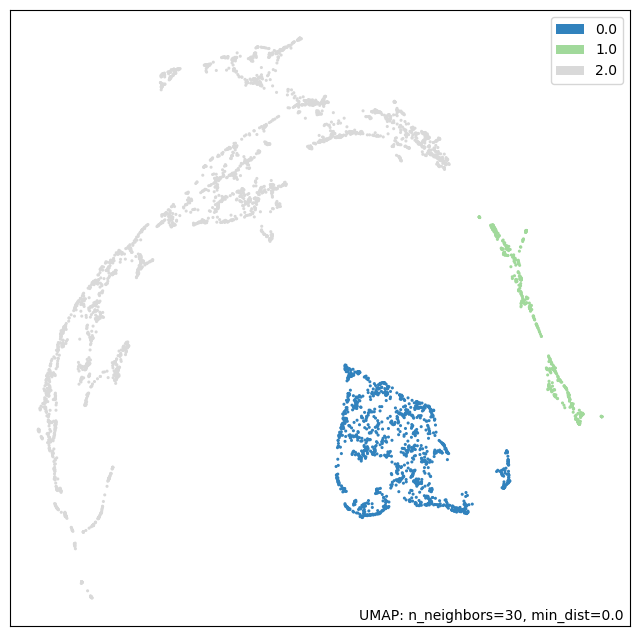

In [7]:
umap.plot.points(mapper, labels = df[:, 17], theme = 'green')

# SAM
The rest of this notebook will consist of experimentation with Facebook research's **SAM**

We start by ensuring that ROI's cropped using the DNA images properly overlay onto the Phase images

In [56]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

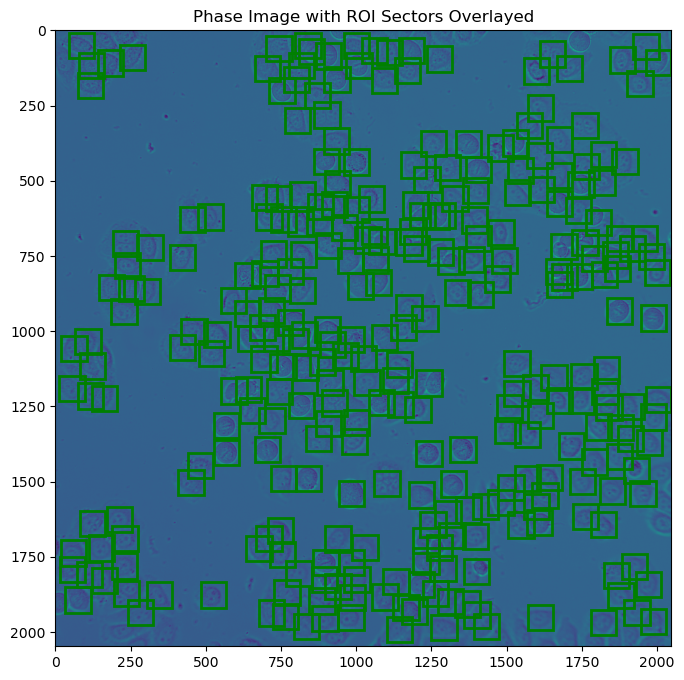

In [29]:
phase = tiff.imread('/Users/whoisv/cell_seg_classify/phase.tiff', key = 0)
fix, ax = plt.subplots(1, figsize = (8,8))
ax.imshow(phase)
ax.set_title('Phase Image with ROI Sectors Overlayed')

for i in range(301):
    box = instance.coords[f'Frame_0_cell_{i}']
    show_box(box, ax)

plt.show()

In [11]:
%%capture
%pip install torch torchvision torchaudio
import torch
import torchvision
import sys

In [12]:
%%capture
%pip install git+https://github.com/facebookresearch/segment-anything.git

In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)


predictor = SamPredictor(sam)

In [49]:
boxes = torch.empty((301, 4))

for i in range(301):
    coord = np.array(instance.coords[f'Frame_0_cell_{i}'])
    boxes[i] = torch.tensor(coord, device =sam.device)

In [50]:
processed_phase = (phase * 0.255) - phase.min()
ph2 = np.zeros( ( np.array(processed_phase).shape[0], np.array(processed_phase).shape[1], 3 ) )
ph2[:,:,0] = processed_phase
ph2[:,:,1] = processed_phase
ph2[:,:,2] = processed_phase
ph2 = ph2.astype('uint8')



In [51]:
predictor.set_image(ph2)
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=boxes,
    multimask_output=False,
)

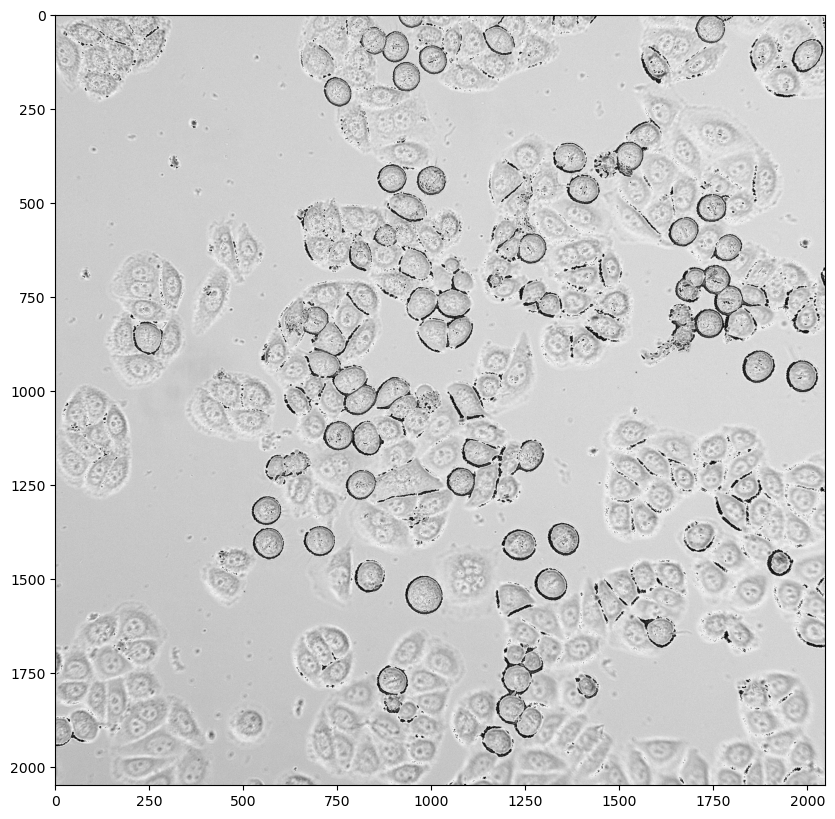

In [55]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.imshow(ph2)
while i < 30:
  for mask in masks:
    show_mask(mask, ax, random_color = True)
    i += 1

plt.show()
